# Lesson 7| Road to the Top & Collaborative Filtering
> Embeddings and Iterating on Work

> Checkout this notebook in [colab](https://colab.research.google.com/github/nglillywhite/blog/blob/main/posts/2023-02-21%20Fastai%20Lesson%207.ipynb)

## Lecture Content

### Kaggle Gangster Time

Ok now its time to tackle the 'road to the top' series that Jeremy walks through as part of Lesson 6 and 7. I'd also like to take on a new dataset/competition instead of being handheld through the paddy disease detection that Jeremy walks through in this lesson and I'm interested to see how transferable the practices are, as well as take on any new problems we get exposed to.

I'll repeat this work with a new competition after I work through the paddy example to get a feel for the kind of workflow shown

I'm going to instead work on the plant-pathology competition which detects diseases in apple trees. I know I'm not taking a huge leap from the paddy detection competition but I wanted to try something similar enough that the concepts are related however I have a totally fresh dataset and different inputs.


In [ ]:
# install fastkaggle if not available
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *

comp = 'paddy-disease-classification'
path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

100%|█████████████████████████████████████████████████████████████████████████████| 1.02G/1.02G [03:20<00:00, 5.44MB/s]


In [ ]:
from fastai.vision.all import *

In [ ]:
set_seed(17)
path.ls()

(#4) [Path('paddy-disease-classification/sample_submission.csv'),Path('paddy-disease-classification/test_images'),Path('paddy-disease-classification/train.csv'),Path('paddy-disease-classification/train_images')]

Ok so we can see our path and submission examples etc, lets have a look at some of the data

In [ ]:
train_path = path/'train_images'
files = get_image_files(train_path)

(480, 640)


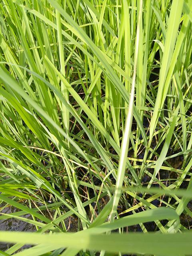

In [ ]:
img = PILImage.create(files[0])
print(img.size)
img.to_thumb(256)

As is done in the road to the top, lets validate what sizes we have in our dataset. There's a couple of cool things such as the parallel function which I'm excited to use here, lets check it out.

In [ ]:
%time

from fastcore.parallel import *

def f(o): return PILImage.create(o).size
sizes = parallel(f, files, n_workers=0)
x = pd.Series(sizes).value_counts()
x

CPU times: total: 0 ns
Wall time: 0 ns


(480, 640)    10403
(640, 480)        4
dtype: int64

Almost everything is 480x680 size, we'll deal with the other 4 later

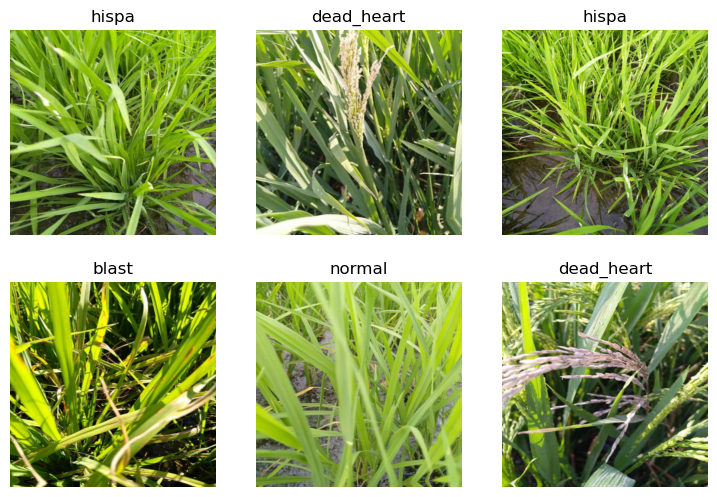

In [ ]:
dls = ImageDataLoaders.from_folder(train_path,
                                  valid_pct=0.2,
                                  seed=42,
                                  item_tfms=Resize(640,method='squish'),
                                  batch_tfms=aug_transforms(size=480, min_scale=0.75))

dls.show_batch(max_n=6)

In [ ]:
def clear_gpu():
    import gc
    gc.collect()
    torch.cuda.empty_cache()

clear_gpu()

In [ ]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 960'

### Gradient Accumulation

Now because I have a stinky little GeForce GTX 960 from the great year of 2015 with 2GB of superpowers, I need to do an awesome thing called gradient accumulation.

This involves only updating the weights after many batches since I can only handle much smaller batches than the 32/64 that you'd usually want to train with and instead, adding/accumulating the gradients. This allows me to train an arbitrarily large/complicated model with whatever effective batch size I like without needing to stump up cash for renting GPU hours or building a whole new PC.

I've implemented this in the callbacks of my dataloader, in particular I think callbacks deserve their own post/blog as their crucial in the fastai library, [Zach Meuller](https://www.youtube.com/watch?v=DIYWATB4B0I) has an awesome video on exactly this. He's also another fastai alumn that I'm totally in awe of, fastai prints legends and I feel so lucky just to be able to read their content.

Also note the **`64//accum` instead of `64/accum`**, this is [integer/floor division in python](https://docs.python.org/3/glossary.html#term-floor-division) and always gives you a rounded down integer of your division result. Super nice little syntax and thought it worthwhile to highlight

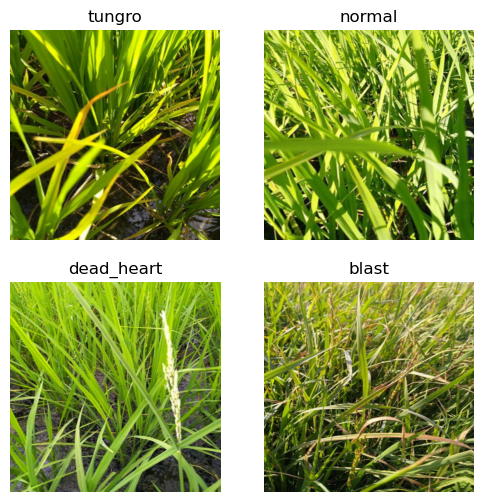

In [ ]:
accum = 16
dls = ImageDataLoaders.from_folder(train_path,
                                  valid_pct=0.2,
                                  seed=42,
                                  item_tfms=Resize(640,method='squish'),
                                  batch_tfms=aug_transforms(size=480, min_scale=0.75),
                                  bs=64//accum)

cbs = GradientAccumulation(64)
learn = vision_learner(dls=dls,
                       arch='resnet26d',
                       metrics=error_rate,
                       path=".",
                       cbs=cbs).to_fp16()

dls.show_batch()

Hey much better! I'm learning about the API with you, I didn't know you could pass a df like this which so many kaggle competitions have as a format, its so awesome. I thought I'd have to whip up something custom by going lower in the API but no of course not, its out of the box

Fastai demands you model first and ask questions later, lets do it

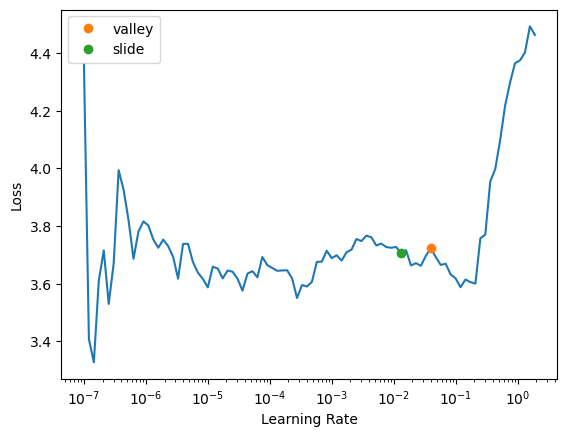

In [ ]:
suggestions = learn.lr_find(suggest_funcs=(valley,slide))

And now we have a set of suggestions from the above visualisation, there seems to be a tiny cliff at 0.04 that its found, 1e-1 looks right, so I might try that.

In [ ]:
suggestions.valley, suggestions.slide

(0.03981071710586548, 0.013182567432522774)

In [ ]:
learn.fine_tune(3,suggestions.valley)

epoch,train_loss,valid_loss,error_rate,time
0,2.076707,1.564426,0.533878,10:52


epoch,train_loss,valid_loss,error_rate,time
0,1.560577,1.140194,0.389236,13:38
1,1.058071,0.842090,0.260452,13:30
2,1.068398,0.673565,0.199423,18:47


OK we have a model on a sample of the data, lets see a submission and just get a score

In [ ]:
ss = pd.read_csv(path / "sample_submission.csv")
ss.head()

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN


In [ ]:
test_files = get_image_files(path/"test_images").sorted()
test_dl = dls.test_dl(test_files)

In [ ]:
probs, dunno, idxs = learn.get_preds(dl=test_dl, with_decoded=True)

In [ ]:
dls.vocab

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

In [ ]:
mapping = dict(enumerate(dls.vocab))
results = pd.Series(idxs.numpy(), name="idxs").map(mapping)
results

0            hispa
1           normal
2       brown_spot
3            blast
4            blast
           ...    
3464    dead_heart
3465         hispa
3466        normal
3467         blast
3468    dead_heart
Name: idxs, Length: 3469, dtype: object

In [ ]:
ss["label"] = results
ss.to_csv("subm.csv",index=False)

'head' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
if not iskaggle:
    from kaggle import api
    api.competition_submit_cli("subm.csv", "initial rn26d 128px", comp)

100%|█████████████████████████████████████████████████████████████████████████████| 71.5k/71.5k [00:04<00:00, 16.7kB/s]


In [ ]:
if not iskaggle:
    push_notebook('nglillywhite2', 'JH-RTTT-kaggle-gangster-1',
                  title='JH-RTTT-kaggle-gangster-1',
                  file='2023-02-21-Fastai Lesson 7.ipynb',
                  competition=comp, private=True, gpu=True)

Kernel version 2 successfully pushed.  Please check progress at https://www.kaggle.com/code/nglillywhite2/jh-rttt-kaggle-gangster-1
